# Цель лабораторной работы
Изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.
# Задание 
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

# Ход выполнения работы


## 1) Набор данных для решения задачи классификации или регрессии

В качестве набора данных мы будем использовать набор данных по распознаванию вин

Эти данные представляют собой результаты химического анализа вин, выращенных в одном и том же регионе Италии тремя разными культиваторами. Было проведено тринадцать различных измерений, проведенных для различных компонентов, содержащихся в трех типах вина.

- Алкоголь

- Яблочная кислота

- Пепел

- Щелочность золы

- Магний

- Общие фенолы

- Флаваноиды

- Нефлаваноидные фенолы

- Проантоцианы

- Интенсивность цвета

- Оттенок

- OD280 / OD315 разбавленных вин

- Пролайн

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")
from sklearn.datasets import *


In [3]:
wine = load_wine()

In [4]:
wine['feature_names']

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [5]:
wine['target_names']

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [6]:
wine['data'].shape

(178, 13)

In [7]:
wine['target'].shape

(178,)

In [8]:
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= list(wine['feature_names']) + ['target'])

In [9]:
data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [10]:
# Значения целевого признака
np.unique(wine.target)

array([0, 1, 2])

In [11]:
# Наименования значений целевого признака
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [12]:
list(zip(np.unique(wine.target), wine.target_names))

[(0, 'class_0'), (1, 'class_1'), (2, 'class_2')]

In [13]:
# Значения целевого признака
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [14]:
# Размер выборки
wine.data.shape, wine.target.shape

((178, 13), (178,))

In [15]:
# И выведем его статистические характеристики
data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


## Разделение выборки на обучающую и тестовую

In [16]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.5, random_state=1)

In [17]:
# Размер обучающей выборки
wine_X_train.shape, wine_y_train.shape

((89, 13), (89,))

In [18]:
# Размер тестовой выборки
wine_X_test.shape, wine_y_test.shape

((89, 13), (89,))

In [19]:
np.unique(wine_y_train)

array([0, 1, 2])

In [20]:
np.unique(wine_y_test)

array([0, 1, 2])

In [21]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [22]:
print_class_proportions(wine.target)

Метка 	 Количество 	 Процент встречаемости
0 	 59 	 	 33.15%
1 	 71 	 	 39.89%
2 	 48 	 	 26.97%


In [23]:
# Для обучающей выборки
print_class_proportions(wine_y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 26 	 	 29.21%
1 	 37 	 	 41.57%
2 	 26 	 	 29.21%


In [24]:
# Для тестовой выборки
print_class_proportions(wine_y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 33 	 	 37.08%
1 	 34 	 	 38.2%
2 	 22 	 	 24.72%


In [26]:
# 5 ближайших соседа
cl1_1 = KNeighborsClassifier(n_neighbors=5)
cl1_1.fit(wine_X_train, wine_y_train)
target1_1 = cl1_1.predict(wine_X_test)
len(target1_1), target1_1

(89,
 array([1, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1,
        2, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2,
        0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0,
        1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 0, 1, 0, 2, 2, 1, 0,
        1]))

In [28]:
# 5 ближайших соседа
accuracy_score(wine_y_test, target1_1)

0.7078651685393258

Точность в случае 5 ближайших соседей составляет 70%

In [29]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [32]:
# 5 ближайших соседа
print_accuracy_score_for_classes(wine_y_test, target1_1)

Метка 	 Accuracy
0 	 0.7878787878787878
1 	 0.7352941176470589
2 	 0.5454545454545454


In [33]:
balanced_accuracy_score(wine_y_test, target1_1)

0.6895424836601306

## Mатрица ошибок или Confusion Matrix

In [36]:
# Конвертация целевого признака в бинарный
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [37]:
# Если целевой признак ==2, 
# то будем считать этот случай 1 в бинарном признаке
bin_wine_y_train = convert_target_to_binary(wine_y_train, 2)
list(zip(wine_y_train, bin_wine_y_train))[:10]

[(1, 0),
 (1, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (2, 1),
 (1, 0),
 (1, 0),
 (1, 0)]

In [38]:
bin_wine_y_test = convert_target_to_binary(wine_y_test, 2)
list(zip(wine_y_test, bin_wine_y_test))[:10]

[(2, 1),
 (1, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (2, 1),
 (1, 0),
 (0, 0),
 (2, 1),
 (1, 0)]

In [39]:
# Конвертация предсказанных признаков
bin_target1_1 = convert_target_to_binary(target1_1, 2)

In [40]:
confusion_matrix(wine_y_test, target1_1, labels=[0, 1])

array([[26,  1],
       [ 2, 25]], dtype=int64)

In [42]:
tn, fp, fn, tp = confusion_matrix(bin_wine_y_test, bin_target1_1).ravel()
tn, fp, fn, tp

(54, 13, 10, 12)

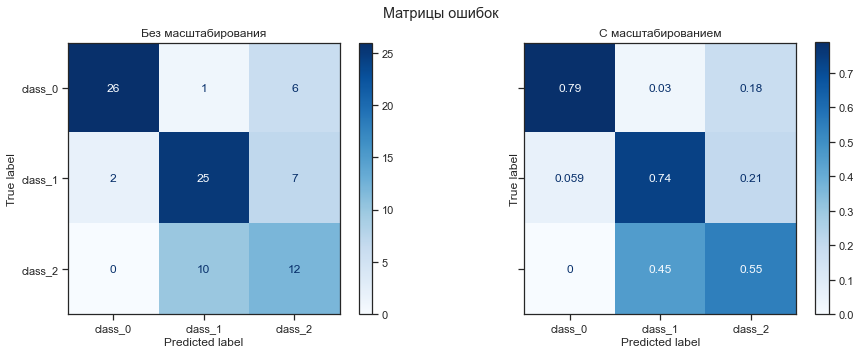

In [43]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, wine_X_test, wine_y_test, 
                      display_labels=wine.target_names, cmap=plt.cm.Blues, ax=ax[0])

plot_confusion_matrix(cl1_1, wine_X_test, wine_y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('Без масштабирования')
ax[1].title.set_text('С масштабированием')

In [44]:
# precision=TP/(TP+FP)
# recall=TP/(TP+FN)
# Для 2 ближайших соседей
precision_score(bin_wine_y_test, bin_target1_1), recall_score(bin_wine_y_test, bin_target1_1)

(0.48, 0.5454545454545454)

In [45]:
# Параметры TP, TN, FP, FN считаются как сумма по всем классам
precision_score(bin_wine_y_test, bin_target1_1, average='micro')

0.7415730337078652

In [46]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется среднее значение, дисбаланс классов не учитывается.
precision_score(bin_wine_y_test, bin_target1_1, average='macro')

0.661875

In [47]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(bin_wine_y_test, bin_target1_1, average='weighted')

0.7538342696629213

## ROC-кривая 

In [52]:
# Обучим модели на задаче бинарной классифкации, 
# чтобы получить вероятности классов

# 5 ближайших соседа
bin_cl1_1 = KNeighborsClassifier(n_neighbors=5)
bin_cl1_1.fit(wine_X_train, bin_wine_y_train)
# предскажем метки классов
bin_cl1_1.predict(wine_X_test)

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0])

In [54]:
# предскажем вероятности классов
proba_target1_1 = bin_cl1_1.predict_proba(wine_X_test)
len(proba_target1_1), proba_target1_1

(89,
 array([[0.6, 0.4],
        [1. , 0. ],
        [0.4, 0.6],
        [0.6, 0.4],
        [1. , 0. ],
        [0.8, 0.2],
        [0.2, 0.8],
        [1. , 0. ],
        [0.4, 0.6],
        [0.8, 0.2],
        [1. , 0. ],
        [0.6, 0.4],
        [1. , 0. ],
        [1. , 0. ],
        [0.4, 0.6],
        [0.8, 0.2],
        [1. , 0. ],
        [0.6, 0.4],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0.4, 0.6],
        [1. , 0. ],
        [0.4, 0.6],
        [0.6, 0.4],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0.4, 0.6],
        [0.8, 0.2],
        [0.4, 0.6],
        [0.6, 0.4],
        [1. , 0. ],
        [0.4, 0.6],
        [1. , 0. ],
        [1. , 0. ],
        [0.6, 0.4],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0.4, 0.6],
        [0.4, 0.6],
        [0.4, 0.6],
        [1. , 0. ],
        [0.4, 0.6],
        [0.6, 0.4],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0

In [55]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

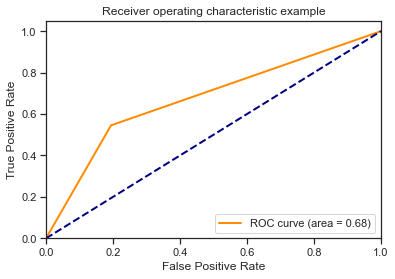

In [56]:
# Для 5 ближайших соседей
draw_roc_curve(bin_wine_y_test, bin_target1_1, pos_label=1, average='micro')

## Кросс-валидация

Стратегия кросс-валидации определяется автоматически.

In [57]:
#кросс-валидации определяется автоматически.
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         wine.data, wine.target, cv=3)

In [58]:
# Значение метрики accuracy для 3 фолдов
scores

array([0.61666667, 0.61016949, 0.76271186])

In [59]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.6631826741996234

In [60]:
# Укажем несколько метрик
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [63]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        wine.data, wine.target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.        , 0.00099921, 0.        ]),
 'score_time': array([0.00499916, 0.00399876, 0.00499964]),
 'test_precision': array([0.60288799, 0.62569982, 0.75448133]),
 'train_precision': array([0.82841208, 0.81069416, 0.75911216]),
 'test_recall': array([0.61666667, 0.61016949, 0.76271186]),
 'train_recall': array([0.83050847, 0.80672269, 0.76470588]),
 'test_f1': array([0.60184394, 0.61521778, 0.75627992]),
 'train_f1': array([0.82918272, 0.80812733, 0.7588654 ])}

### K-fold стратегия

In [64]:
# Возвращаются индексы элементов
X = ["a", "b", "c"]
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2] [0]
[0 2] [1]
[0 1] [2]


In [65]:
X = range(12)
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


In [67]:
%%time
kf = KFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         wine.data, wine.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 18 ms


array([0.92537313, 0.88624339, 0.71428571, 0.78656048, 0.05555556])

In [68]:
np.mean(scores)

0.673603653652538

### Repeated K-fold стратегия

In [70]:
X = range(12)
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 0  1  2  5  7  8 10 11] [3 4 6 9]
[0 1 3 4 6 7 8 9] [ 2  5 10 11]
[ 2  3  4  5  6  9 10 11] [0 1 7 8]
[ 0  1  2  3  5  6  7 11] [ 4  8  9 10]
[ 0  1  4  6  7  8  9 10] [ 2  3  5 11]
[ 2  3  4  5  8  9 10 11] [0 1 6 7]


In [71]:
%%time
kf = RepeatedKFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         wine.data, wine.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 148 ms


array([0.60852907, 0.74055919, 0.73023088, 0.62579365, 0.75005291,
       0.69206349, 0.72016461, 0.68226337, 0.6467033 , 0.72126984,
       0.74456105, 0.70402576, 0.63370521, 0.71153972, 0.68229873,
       0.81600268, 0.58680556, 0.69989316, 0.68391837, 0.64180291,
       0.65663082, 0.74024691, 0.5537037 , 0.75510204, 0.74363181,
       0.68362996, 0.57121212, 0.83651288, 0.74047619, 0.6       ,
       0.63406085, 0.60308642, 0.76785714, 0.75707465, 0.64621819,
       0.6837963 , 0.68765432, 0.75      , 0.62040816, 0.66691087,
       0.66094771, 0.64434948, 0.69853514, 0.63157684, 0.81142857,
       0.67813051, 0.69748792, 0.75286523, 0.82565317, 0.6688172 ])

In [72]:
np.mean(scores)

0.6918037714619042

## Leave One Out (LOO)

In [73]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = LeaveOneOut()
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


In [74]:
%%time
kf = LeaveOneOut()
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         wine.data, wine.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 337 ms


array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0.])

In [75]:
np.mean(scores)

0.6966292134831461

## Подбор гиперпараметров GridSearchCV

In [76]:
wine_X_train.shape

(89, 13)

In [94]:
n_range = np.array(range(1,70,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
         52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
         69])}]

In [95]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(wine_X_train, wine_y_train)

Wall time: 623 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69])}],
             scoring='accuracy')

### Лучшая модель

In [96]:
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=17)

In [97]:
clf_gs.best_params_

{'n_neighbors': 17}

Лучшая модель методом GridSearchCV - для 17 ближайших соседей

### Изменение качества на тестовой выборке в зависимости от К-соседей

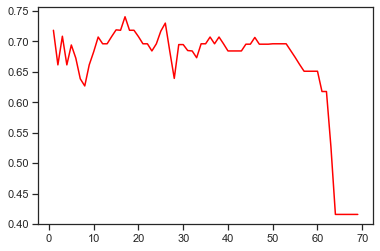

In [98]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'], color="red")

## Подбор гиперпараметров  RandomizedSearchCV 

In [101]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(wine_X_train, wine_y_train)

Wall time: 96 ms


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69])}],
                   scoring='accuracy')

In [102]:
clf_rs.best_score_, clf_rs.best_params_

(0.7189542483660132, {'n_neighbors': 15})

In [103]:
clf_gs.best_score_, clf_gs.best_params_

(0.7405228758169934, {'n_neighbors': 17})

Лучшая модель методом RandomizedSearchCV - для 15 ближайших соседей 

## Качество оптимальной модели.

In [111]:
# 17 ближайших соседа
cl1_3 = KNeighborsClassifier(n_neighbors=17)
cl1_3.fit(wine_X_train, wine_y_train)
target1_3 = cl1_3.predict(wine_X_test)

In [108]:
# Конвертация предсказанных признаков
bin_target1_3 = convert_target_to_binary(target1_3, 2)

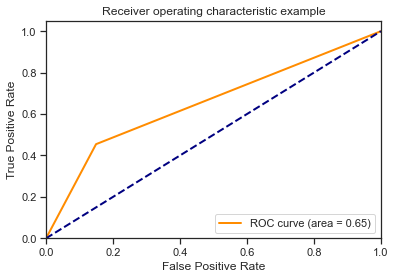

In [112]:
# Для 17 ближайших соседей
draw_roc_curve(bin_wine_y_test, bin_target1_3, pos_label=1, average='micro')

In [114]:
# Для 17 ближайших соседей
print_accuracy_score_for_classes(wine_y_test, target1_3)

Метка 	 Accuracy
0 	 0.8484848484848485
1 	 0.7352941176470589
2 	 0.45454545454545453


In [115]:
# 15 ближайших соседа
cl1_4 = KNeighborsClassifier(n_neighbors=15)
cl1_4.fit(wine_X_train, wine_y_train)
target1_4 = cl1_4.predict(wine_X_test)

In [116]:
# Конвертация предсказанных признаков
bin_target1_4 = convert_target_to_binary(target1_4, 2)

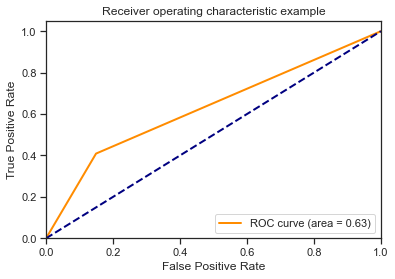

In [117]:
# Для 16 ближайших соседей
draw_roc_curve(bin_wine_y_test, bin_target1_4, pos_label=1, average='micro')

In [118]:
# Для 16 ближайших соседей
print_accuracy_score_for_classes(wine_y_test, target1_4)

Метка 	 Accuracy
0 	 0.8484848484848485
1 	 0.7647058823529411
2 	 0.4090909090909091


## Сравнение метрики качества исходной и оптимальной модели 

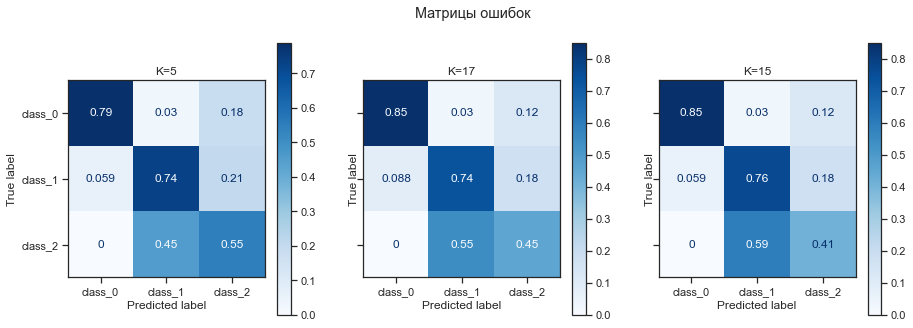

In [121]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, wine_X_test, wine_y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(cl1_3, wine_X_test, wine_y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

plot_confusion_matrix(cl1_4, wine_X_test, wine_y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[2])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=5')
ax[1].title.set_text('K=17')
ax[2].title.set_text('K=15')